In [52]:
import numpy as np
import sys
import time
import warnings
import matplotlib.pyplot as plt
import os
warnings.filterwarnings('ignore')
import math
import random

In [1]:
'''
Class MarkovDP contains the following attributes:
1)Number of states  : s
2)Number of actions : a
3)Dimension of parameter space : d
4)Number of iterations T
5)State Space
6)Action Space
7)Transition probability matrix of size (a,s,s)
8)Reward matrix (a,s,s)
9) Feature approximation vector of size (a,s,d) for score function and policy update
10) Feature approximation vector phi of size (s,d) for Temporal Difference Error update
11) policy pi of size (s,a)
12) optimal policy of size (s,a) for testing
13) Temporal Difference Error (a,s,s)
14) initial probability distribution xi
15) discount factor
16) critic parameter thetas 
17) action value function
'''
class MarkovDP:
    
    def __init__(self,s,a,d,T, discount_factor):
        self.num_state             = s
        self.num_action            = a
        self.dimension             = d
        self.states                = np.array(range(0,s))
        self.actions               = np.array(range(0,a))
        self.transitions           = np.zeros((a,s,s))
        self.rewards               = np.zeros((a,s,s))
        self.feature_approx        = np.zeros((a,s,d))
        self.phi                   = np.zeros((s,d))
        self.pi                    = np.zeros((s, a))
        self.optimal_pi            = np.zeros((s, a))
        self.TDerror               = np.zeros((a,s,s))
        self.xi                    = np.zeros(s)
        self.discount_factor       = discount_factor
        self.thetas                = np.zeros((T+1, d))
        self.action_value          = np.zeros((s,a))
        
    #mdp created to test the policy_eval and optimal_policyValue methods
    def test_mdp(self):
        self.transitions[0] = [[0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1], [1,0,0,0,0]]
        self.transitions[1] = [[1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1]]
        self.transitions[2] = [[0,0,0,0,1], [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0]]
        self.feature_approx = np.random.rand(self.num_action, self.num_state, self.dimension)
        self.phi = np.random.rand(self.num_state, self.dimension)
        self.thetas[0] = np.random.rand(self.dimension)
        self.xi = np.full((self.num_state), (1.0/self.num_state))
        for i in range(0,5):
            for j in range(0,5):
                self.rewards[0][i][j] = 1.0
                self.rewards[1][i][j] = 0.5
                self.rewards[2][i][j] = 0
        for i in range(0, self.num_state):
            self.pi[i] = np.full((self.num_action), (1.0/self.num_action))
            self.optimal_pi[i] = np.full((self.num_action), (1.0/self.num_action))
      
    #initializes MDP
    def initialize_mdp(self):   
      #for reproducibility  
        self.rewards = np.random.rand(self.num_action, self.num_state, self.num_state)
        self.feature_approx = np.random.rand(self.num_action, self.num_state, self.dimension)
        self.phi = np.random.rand(self.num_state, self.dimension)
        self.thetas[0] = np.random.rand(self.dimension)
        self.xi = np.full((self.num_state), (1.0/self.num_state))
        for i in range (0, self.num_action):
            for j in range(0, self.num_state):
                self.transitions[i][j] = np.random.dirichlet(np.ones(self.num_state, dtype = np.int8),size=1)
        for i in range(0, self.num_state):
            self.pi[i] = np.random.dirichlet(np.ones(self.num_action, dtype = np.int8),size=1)
            self.optimal_pi[i] = np.random.dirichlet(np.ones(self.num_action, dtype = np.int8),size=1)
    
    #log gradient of policy
    def score_function(self, action, state):
        score = self.feature_approx[action][state]
        for i in range(0, self.num_action):
            score = score - (self.pi[state][i] * self.feature_approx[i][state])
        return score
    
    #updates the policy using a softmax function
    def update_policy(self, actor_parameter):
        for i in range(0, self.num_state):
            pi_sum = 0
            for j in range(0, self.num_action):
                pi_sum += math.exp(np.dot(actor_parameter, self.feature_approx[j][i]))
            for j in range(0, self.num_action):
                self.pi[i][j] = ((math.exp(np.dot(actor_parameter, self.feature_approx[j][i]))) / pi_sum)
    
    #evaluates the policy and finds its value function
    def policy_eval(self, pi, gamma):
        policy_rewards = np.zeros(self.num_state)
        for i in range(0, self.num_state):
            total_sum = 0
            for j in range(0, self.num_action):
                reward_sum = 0
                for k in range(0, self.num_state):
                    reward_sum += (self.rewards[j][i][k] * self.transitions[j][i][k])
                total_sum += (pi[i][j] * reward_sum)
            policy_rewards[i] = total_sum
        policy_transitions = np.zeros((self.num_state, self.num_state))
        for i in range(0, self.num_state):
            for j in range(0, self.num_state):
                reward_sum = 0
                for k in range(0, self.num_action):
                    reward_sum += (self.transitions[k][i][j] * pi[i][k])
                policy_transitions[i][j] = reward_sum
        value_func = (np.dot(np.linalg.inv(np.identity(self.num_state) - (gamma * policy_transitions)),policy_rewards))
        return value_func
    
    #calculates the optimal policy for the given MDP
    def optimal_policyValue(self):
        policy_stable = False
        value_func = self.policy_eval(self.optimal_pi, self.discount_factor)
        while(not policy_stable):
            policy_stable= True
            for i in range(0, self.num_state):
                old_action = np.random.choice(self.actions, p = self.optimal_pi[i])
                max = np.zeros(2)
                for j in range(0, self.num_action):
                    reward_sum = 0
                    for k in range(0, self.num_state):
                        reward_sum += (self.transitions[j][i][k] * (self.rewards[j][i][k] + (self.discount_factor * value_func[k])))
                    if (reward_sum > max[0]):
                        max[0] = reward_sum
                        max[1] = j
                policy_dist = np.zeros(self.num_action)
                policy_dist[int(max[1])] = 1
                self.optimal_pi[i] = policy_dist
                if (old_action != np.random.choice(self.actions, p = self.optimal_pi[i])):
                    policy_stable = False
        value_func = self.policy_eval(self.optimal_pi, self.discount_factor)
        return value_func
    
    #sample action-value function
    def q_sampling(self, s, a ,pi):
        T = np.random.geometric(p=(1.0 - math.sqrt(self.discount_factor)))
        states = np.zeros(T+1, dtype = int)
        actions = np.zeros(T+1, dtype = int)
        states[0] = s
        actions[0] = a
        for i in range(0, T):
            states[i+1] = np.random.choice(self.states, p = self.transitions[actions[i-1]][states[i-1]][:])
            self.action_value[s][a] = self.action_value[s][a] + (math.pow(self.discount_factor, (i/2.0)) * self.rewards[actions[i]][states[i]][states[i+1]])
            actions[i+1] = np.random.choice(self.actions, p = pi[states[i+1]])
        return self.action_value[s][a]
    
    #projection of y onto ball with given radius
    def projection(self, radius, y):
        denom = max(radius, np.linalg.norm(y))
        return ((y / denom))
    
    #runs the two time actor critic algorithm
    def two_time_ac(self, regularization, T, isNAC, sigma , upsilon):
        actor_parameter = np.zeros((T+1,self.dimension))
        #actor_parameter[0] = np.random.rand(self.dimension)
        self.update_policy(actor_parameter[0])
        states = np.zeros(T, dtype = int)
        actions = np.zeros(T, dtype = int)
        actions2 = np.zeros(T, dtype = int)
        g = np.zeros((T, d))
        optimal_value = self.optimal_policyValue()
        optimal_value = (np.sum(optimal_value) / self.num_state)
        value_diff = np.zeros(T)
        for i in range(0, T):
            actor_stepsize = (1.0 / math.pow(i+1.0,sigma))
            critic_stepsize = (1.0 / math.pow(i+1.0,upsilon))
            if (i == 0):
                states[i] = np.random.choice(self.states, p = self.xi)
            else:
                states[i] = np.random.choice(self.states, p = ((self.discount_factor * self.transitions[actions[i-1]][states[i-1]][:]) + ((1 - self.discount_factor) * self.xi)))
            actions[i] = np.random.choice(self.actions, p = self.pi[states[i]])
            actions2[i] = np.random.choice(self.actions, p = self.pi[states[i]])
            self.action_value[states[i]][actions[i]] = self.q_sampling(states[i], actions[i], self.pi)
            g[i] = (((-np.dot(self.score_function(actions[i], states[i]), self.thetas[i]) + self.action_value[states[i]][actions[i]]) * self.score_function(actions[i], states[i])) - (self.action_value[states[i]][actions[i]] * self.score_function(actions2[i], states[i])) - (regularization * self.thetas[i]))
            radius = (math.pow(1.0-self.discount_factor,-1) * math.pow(regularization, -1))
            self.thetas[i+1] = self.projection(radius, (self.thetas[i] + (critic_stepsize * g[i])))
            if (not isNAC):
                actor_parameter[i+1] = actor_parameter[i] + (actor_stepsize * np.dot(self.score_function(actions[i], states[i]), self.thetas[i]) * self.score_function(actions[i], states[i]))
                self.update_policy(actor_parameter[i+1])
                #to test whether the algorithm converges
                value_func = self.policy_eval(self.pi, self.discount_factor)
                value_diff[i] = (optimal_value - (np.sum(value_func) / self.num_state))
            else:
                actor_parameter[i+1] = actor_parameter[i] + (actor_stepsize * self.thetas[i])
                self.update_policy(actor_parameter[i+1])
                #to test whether the algorithm converges
                value_func = self.policy_eval(self.pi, self.discount_factor)
                value_diff[i] = (optimal_value - (np.sum(value_func) / self.num_state))
        return (actor_parameter[np.random.randint(0,T)], np.arange(T), value_diff)

In [54]:
d = 6
env = MarkovDP(5,3,d,700, 0.9)
env.initialize_mdp()

In [55]:
wT, x, y = env.two_time_ac(0.9, 700, True, 0.75, 0.5)

[0.74942136 1.05676962 0.24684488 1.06818802 0.12173062 1.29618708]


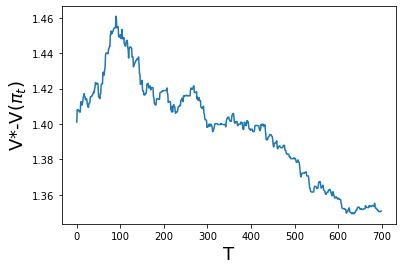

In [56]:
%matplotlib inline
plt.xlabel('T', fontsize=18)
plt.ylabel('V*-V($\pi_t$)', fontsize=18)
plt.plot(x, y)
plt.show()

[45 52 16 33 95]
